In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# First use inspector to examine the data

inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Query the date data, ordering the dates in descending order to get the most recent first
recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(recent_date)


('2017-08-23',)


In [12]:
# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
# Find the actual date
last_date = dt.date(one_year.year, one_year.month, one_year.day)
last_date


datetime.date(2016, 8, 23)

In [13]:
# Filter the results to retrieve only the values after August 23, 2016
one_year_values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_date).\
    order_by(Measurement.date)

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(one_year_values, columns=['Date', 'Precipitation'])

# Clean up the data by dropping any columns with no data and setting the date column
# as the index 
precip_df = precip_df.dropna()
precip_df.set_index('Date', inplace=True)
precip_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


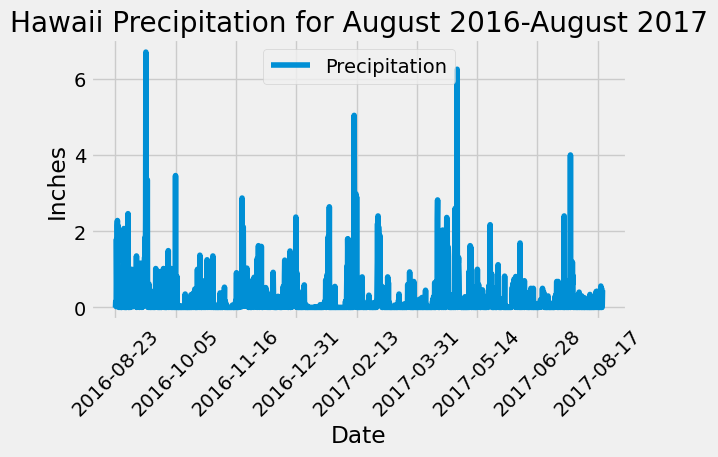

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45)
# Limit the x ticks so that only one per month is displayed
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Hawaii Precipitation for August 2016-August 2017")
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Use the inspector to examine the station data
station_columns = inspector.get_columns("station")
for col in station_columns:
    print(col["name"], col["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:

# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(func.count(Station.station)).scalar()
print(number_stations)

9


In [19]:
station_names = session.query(Station.station).all()

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# In order to so this, we have to find the station that has the most measurements listed in the measurement data 
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# To do this, use the tobs (temperature observation data) column from the measurement data 
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

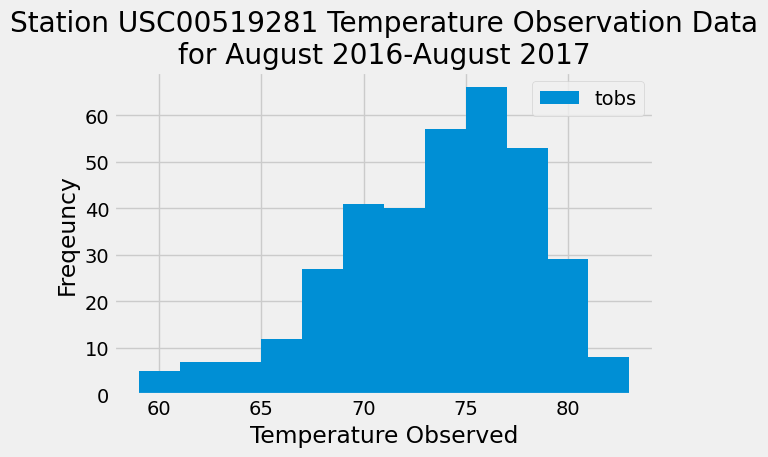

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_date).all()

tobs_df = pd.DataFrame(one_year_tobs, columns=['tobs'])
tobs_df.plot.hist(bins=12)
plt.xlabel('Temperature Observed')
plt.ylabel('Freqeuncy')
plt.title('Station USC00519281 Temperature Observation Data\nfor August 2016-August 2017')
plt.tight_layout()
plt.show()

# Close Session

In [23]:
# Close Session
session.close()